In [1]:
import sys
sys.path.append('../../../')

In [2]:
from win10toast import ToastNotifier
toast = ToastNotifier()

In [3]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train_reg import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error, mean_absolute_error

Using backend: pytorch


In [4]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [5]:
do_train = False

seed = 4444
set_seed(seed)

metric_filter_1 = 'test_rmse_perc'
metric_filter_2 = 'val_rmse_perc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [6]:
sets_lengths = (0.3, 0.1, 0.6)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = 1

## Baseline

### FNN

In [7]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[100], [100] * 2, [100] * 3, [200], [200]*2,[200]*3,[500],[500]*2,[500]*3],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [8]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=200,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=False,
            loss_type='mse',
            scheduler_patience=20,
        )

100%|██████████| 54/54 [16:12<00:00, 18.00s/it]


#### Results

In [9]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 1134/1134 [00:55<00:00, 20.25it/s]


In [10]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [100, 100, 100],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 20,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.47217798,
 'train_acc': 0.5658198595046997,
 'val_acc': 0.5972221493721008,
 'epoch': 120,
 'model_class': 'fnn',
 'path_name': '4_[100_100_100]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_False_mse_20_False_0_120',
 'train_rmse': 0.7778694179672935,
 'val_rmse': 0.8207381501496754,
 'test_rmse': 0.8638584616435564,
 'train_rmse_perc': 0.18474239,
 'val_rmse_perc': 0.20527034,
 'test_rmse_perc': 0.2150988,
 'train_mcc': 0.42325361199267797,
 'val_mcc': 0.4572086352196384,
 'test_mcc': 0.46907929792604003,
 'test_acc': 0.5997692942619324}

In [11]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [100, 100, 100],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 20,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.47204483,
 'train_acc': 0.5658198595046997,
 'val_acc': 0.5972221493721008,
 'epoch': 150,
 'model_class': 'fnn',
 'path_name': '4_[100_100_100]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_False_mse_20_False_0_150',
 'train_rmse': 0.7823101928744689,
 'val_rmse': 0.8207381501496754,
 'test_rmse': 0.8698460005026994,
 'train_rmse_perc': 0.18467923,
 'val_rmse_perc': 0.20516615,
 'test_rmse_perc': 0.21503495,
 'train_mcc': 0.42344654773301776,
 'val_mcc': 0.4572086352196384,
 'test_mcc': 0.46918812173565316,
 'test_acc': 0.5997692942619324}

In [12]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [200, 200, 200],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 20,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.451688,
 'train_acc': 0.5866050720214844,
 'val_acc': 0.6041666269302368,
 'epoch': 100,
 'model_class': 'fnn',
 'path_name': '4_[200_200_200]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_False_mse_20_False_0_100',
 'train_rmse': 0.791116964050395,
 'val_rmse': 0.7772815877574012,
 'test_rmse': 0.8678547441698324,
 'train_rmse_perc': 0.18236464,
 'val_rmse_perc': 0.20154873,
 'test_rmse_perc': 0.21298128,
 'train_mcc': 0.4515047755456906,
 'val_mcc': 0.47990645972856927,
 'test_mcc': 0.43821417219732,
 'test_acc': 0.5790081024169922}

In [13]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1134/1134 [00:00<00:00, 15443.42it/s]


### GCN

In [ ]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[10] * 3],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0,],
#     use_edge_weight=[True, ],
#     drop_edges=[0,0.2],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [ ]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

#### Results

In [ ]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

In [ ]:
res_edges = res_edges_gcn
res_edges[0]

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

In [ ]:
pretty([all[k]['dict'] for k in sort_idx])

### GraphSAGE

In [14]:
save_model = f'{save_path}_sage'
log_dir = f'{log_path}_sage'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['right', 'none'],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0.2, 0],
#     # other
#     lr=[1e-2],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0,0.2],
# )
# list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[500]*2], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['none'],
    norm_nodes = ['gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0, 0.2],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0, 0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [15]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=2000,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=50,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            scheduler_patience=300,
        )

100%|██████████| 4/4 [1:46:55<00:00, 1603.81s/it]


#### Results

In [16]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

toast.show_toast("Done")

100%|██████████| 164/164 [01:31<00:00,  1.78it/s]


True

In [17]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.17579426,
 'train_acc': 0.8706697225570679,
 'val_acc': 0.6319443583488464,
 'epoch': 1450,
 'model_class': 'sage',
 'path_name': '4_[500_500]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_300_True_0.2_1450',
 'train_rmse': 0.3596251576872375,
 'val_rmse': 0.8897565210026093,
 'test_rmse': 0.8631906158060839,
 'train_rmse_perc': 0.11168544,
 'val_rmse_perc': 0.2318133,
 'test_rmse_perc': 0.22103187,
 'train_mcc': 0.8283751434379268,
 'val_mcc': 0.504528366240256,
 'test_mcc': 0.5251785204789058,
 'test_acc': 0.6412917971611023}

In [18]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.17579426,
 'train_acc': 0.8706697225570679,
 'val_acc': 0.6319443583488464,
 'epoch': 1450,
 'model_class': 'sage',
 'path_name': '4_[500_500]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_300_True_0.2_1450',
 'train_rmse': 0.3596251576872375,
 'val_rmse': 0.8897565210026093,
 'test_rmse': 0.8631906158060839,
 'train_rmse_perc': 0.11168544,
 'val_rmse_perc': 0.2318133,
 'test_rmse_perc': 0.22103187,
 'train_mcc': 0.8283751434379268,
 'val_mcc': 0.504528366240256,
 'test_mcc': 0.5251785204789058,
 'test_acc': 0.6412917971611023}

In [19]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.098837644,
 'train_acc': 0.8914549946784973,
 'val_acc': 0.6805554628372192,
 'epoch': 1550,
 'model_class': 'sage',
 'path_name': '4_[500_500]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_300_True_0_1550',
 'train_rmse': 0.32946173471593376,
 'val_rmse': 0.7949493345141213,
 'test_rmse': 0.8387941033806838,
 'train_rmse_perc': 0.106487125,
 'val_rmse_perc': 0.21275133,
 'test_rmse_perc': 0.21837124,
 'train_mcc': 0.857821037762977,
 'val_mcc': 0.5672426363380845,
 'test_mcc': 0.5177348140969384,
 'test_acc': 0.6297577619552612}

In [20]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 164/164 [00:00<00:00, 20556.01it/s]


#### cm

In [21]:
cm = all[sort_idx[0]]['test_cm'][0]

In [22]:
(cm.labels==0).sum()

tensor(230)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

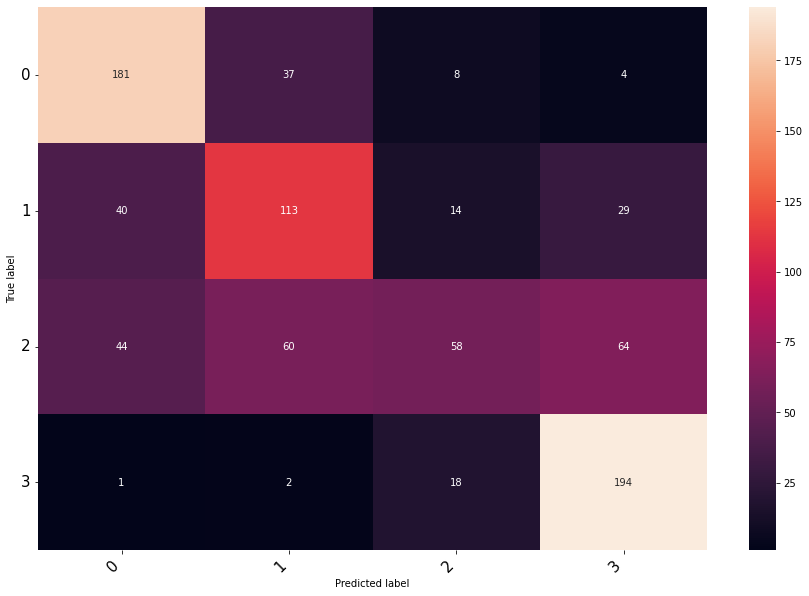

In [23]:
cm.visualize()

In [24]:
cm.class_accuracy

tensor([0.7870, 0.5765, 0.2566, 0.9023])

In [25]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.17763509, 0.2611884, 0.27546555, 0.12878902]

In [26]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.11359891, 0.18939438, 0.22494318, 0.09887825]

#### GraphSAGE Base_n

In [27]:
save_model = f'{save_path}_sage'
log_dir = f'{log_path}_sage'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['right', 'none'],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0.2, 0],
#     # other
#     lr=[1e-2],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0,0.2],
# )
# list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[500]*2], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['none'],
    norm_nodes = ['gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0, 0.2],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0, 0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [28]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=2000,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=50,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            scheduler_patience=300,
            base_n=True,
        )

100%|██████████| 4/4 [1:44:24<00:00, 1566.17s/it]


##### Results

In [29]:
res_edges_sage_base = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    base_n=True,
)

toast.show_toast("Done")

100%|██████████| 164/164 [01:01<00:00,  2.66it/s]


True

In [30]:
res_edges = res_edges_sage_base
res_edges[0]

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.13727318,
 'train_acc': 0.6143187284469604,
 'val_acc': 0.5347221493721008,
 'epoch': 950,
 'model_class': 'sage',
 'path_name': '4_[500_500]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_300_True_0_950',
 'train_rmse': 0.6429579451010705,
 'val_rmse': 0.982485510212633,
 'test_rmse': 1.0057504786848754,
 'train_rmse_perc': 0.15080845,
 'val_rmse_perc': 0.2486679,
 'test_rmse_perc': 0.25515032,
 'train_mcc': 0.4931840239006779,
 'val_mcc': 0.39696798110365905,
 'test_mcc': 0.37372178392555483,
 'test_acc': 0.523644745349884}

In [31]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.13727318,
 'train_acc': 0.6143187284469604,
 'val_acc': 0.5347221493721008,
 'epoch': 950,
 'model_class': 'sage',
 'path_name': '4_[500_500]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_300_True_0_950',
 'train_rmse': 0.6429579451010705,
 'val_rmse': 0.982485510212633,
 'test_rmse': 1.0057504786848754,
 'train_rmse_perc': 0.15080845,
 'val_rmse_perc': 0.2486679,
 'test_rmse_perc': 0.25515032,
 'train_mcc': 0.4931840239006779,
 'val_mcc': 0.39696798110365905,
 'test_mcc': 0.37372178392555483,
 'test_acc': 0.523644745349884}

In [32]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.13727318,
 'train_acc': 0.6143187284469604,
 'val_acc': 0.5347221493721008,
 'epoch': 950,
 'model_class': 'sage',
 'path_name': '4_[500_500]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_300_True_0_950',
 'train_rmse': 0.6429579451010705,
 'val_rmse': 0.982485510212633,
 'test_rmse': 1.0057504786848754,
 'train_rmse_perc': 0.15080845,
 'val_rmse_perc': 0.2486679,
 'test_rmse_perc': 0.25515032,
 'train_mcc': 0.4931840239006779,
 'val_mcc': 0.39696798110365905,
 'test_mcc': 0.37372178392555483,
 'test_acc': 0.523644745349884}

In [33]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 164/164 [00:00<00:00, 3410.04it/s]


##### cm

In [34]:
cm = all[sort_idx[0]]['test_cm'][0]

In [35]:
(cm.labels==0).sum()

tensor(230)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

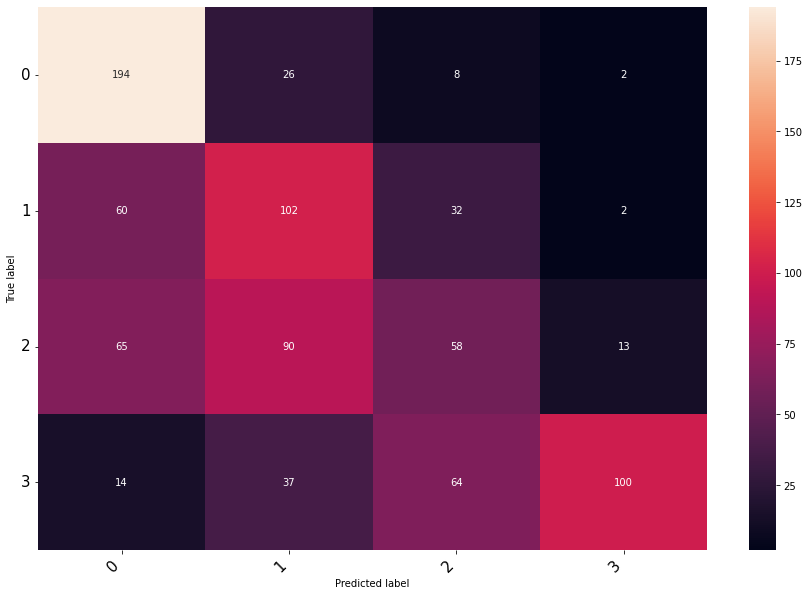

In [36]:
cm.visualize()

In [37]:
cm.class_accuracy

tensor([0.8435, 0.5204, 0.2566, 0.4651])

In [38]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.15124048, 0.21564004, 0.30826402, 0.30947864]

In [39]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.09643204, 0.17735752, 0.26463476, 0.23055303]

### GAT

In [ ]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    use_edge_weight=[False],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [ ]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

#### Results

In [ ]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

In [ ]:
res_edges = res_edges_gat
res_edges[0]

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

In [ ]:
pretty([all[k]['dict'] for k in sort_idx])